<a href="https://colab.research.google.com/github/flrain2/Study/blob/main/create_5fold_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Keras Data Split 제공 함수
### 1) 2개 그룹 생성(Train/Test)
### 2) 번호별 비율 제어 어려움(random)
- StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
- RepeatedStratifiedKFold(n_splits=2, n_repeats=2,random_state=3684)
- KFold(n_splits=2, random_state=None, shuffle=False)


## => Cross Validation Set Manual 생성
###1) 번호별 5개 fold 생성
###2) 20가지 경우의 수 만큼 Dataset 생성
- Train(60%) / Validation(20%) / Test(20%)


In [1]:
import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

import itertools

# import tensorflow as tf
# from torch import nn
# import torchvision.transforms as tr
# from sklearn.model_selection import KFold

In [2]:
DataDir = '/content/drive/MyDrive/Data/'
MdlDir = '/content/drive/MyDrive/Algorithm/NN/Mnist_Load_NN/Pytorch/Model/'

## 1. MNIST Download -> Train/Test Data Concate
 - datasets.MINST
 - ConcatDataset

In [3]:
## MNIST Data down 받기

# 공개 데이터셋에서 학습 데이터를 내려받습니다.
train = datasets.MNIST(
    root=DataDir,
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test = datasets.MNIST(
    root=DataDir,
    train=False,
    download=True,
    transform=ToTensor(),
)
# 데이터 합치기
tot_dataset = ConcatDataset([train, test])
print("length of training_data: ", len(train))
print("length of test_data: ", len(test))
print("length of tot_dataset: ", len(tot_dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Data/MNIST/raw

length of training_data:  60000
length of test_data:  10000
length of tot_dataset:  70000


In [4]:
print("train:", type(train), "tot_dataset", type(tot_dataset))

train: <class 'torchvision.datasets.mnist.MNIST'> tot_dataset <class 'torch.utils.data.dataset.ConcatDataset'>


# 2. 0~9 번호별 fold 5개 생성 
### 1) Image Data/Label 분리
### 2) 숫자(0~9) 및 Image Data/Label별 5개 fold 만들기
### 3) 5개 fold 만들기(0~9번호 합치기)
#### 참고)생성 dataset(100개) : 숫자(10개) * fold(5개) * Image data/label(2개)
- chunk : fold 생성
- globals() : 변수별 가변인자 

In [5]:
# Image Data, label numpy 만들기
X, label = zip(*tot_dataset) #unzip
X_np = np.array(X)
label_np = np.array(label)

# 0~9 번호별 건수
number, counts = np.unique(label_np, return_counts=True)
uniq_cnt = dict(zip(number, counts))
uniq_cnt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing im

{0: 6903,
 1: 7877,
 2: 6990,
 3: 7141,
 4: 6824,
 5: 6313,
 6: 6876,
 7: 7293,
 8: 6825,
 9: 6958}

In [6]:
# 번호별 5개 fold image data, labe 만들기
for number in range(10):
# label index, label 값, 이미지 data 생성
  # label
  idx_label = np.where(label_np == number)[0]
  idx_lb_data = label_np[idx_label]
  # Image Data
  idx_data_tmp = X_np[idx_label]
  idx_data_np=np.vstack(idx_data_tmp).astype(np.float)
  idx_data = torch.Tensor(idx_data_np)

# 5개 fold Image data 만들기 : 예)번호 0, 첫번째 fold Image Data -> idx_data_0_0
  # 5개 fold 지정
  chunks = idx_data.chunk(5)

  # fold별 Image Data 생성
  for idx, data in enumerate(chunks):
    globals()["idx_data_"+str(number)+"_"+str(idx)] = data

# 5개 fold label data 만들기 : 예)번호 0, 첫번째 fold label Data -> idx_lb_data_0_0     
  # fold별 Image Data 건수정보 list 만들기
  num_idx = [len(globals()["idx_data_"+str(number)+"_0"]),
            len(globals()["idx_data_"+str(number)+"_1"]),
            len(globals()["idx_data_"+str(number)+"_2"]),
            len(globals()["idx_data_"+str(number)+"_3"]),
            len(globals()["idx_data_"+str(number)+"_4"])]

  # fold별 Image Data건수 만큼 label Data 만들기
  for idx, num in enumerate(num_idx):
    globals()["idx_lb_data_"+str(number)+"_"+str(idx)] = idx_lb_data[:num]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


In [7]:
#  fold별로 합치기 : Image data/Label별 5개 fold 생성
for fold in range(5):
  # Image Data
  globals()["idx_data_fold_"+str(fold)] = torch.cat((globals()["idx_data_0_"+str(fold)],
                                                      globals()["idx_data_1_"+str(fold)],
                                                      globals()["idx_data_2_"+str(fold)],
                                                      globals()["idx_data_3_"+str(fold)],
                                                      globals()["idx_data_4_"+str(fold)],
                                                      globals()["idx_data_5_"+str(fold)],
                                                      globals()["idx_data_6_"+str(fold)],
                                                      globals()["idx_data_7_"+str(fold)],
                                                      globals()["idx_data_8_"+str(fold)],
                                                      globals()["idx_data_9_"+str(fold)])
                                                      ,0)
  # label Data   
  globals()["idx_lb_fold_"+str(fold)] = np.concatenate((globals()["idx_lb_data_0_"+str(fold)],
                                                    globals()["idx_lb_data_1_"+str(fold)],
                                                    globals()["idx_lb_data_2_"+str(fold)],
                                                    globals()["idx_lb_data_3_"+str(fold)],
                                                    globals()["idx_lb_data_4_"+str(fold)],
                                                    globals()["idx_lb_data_5_"+str(fold)],
                                                    globals()["idx_lb_data_6_"+str(fold)],
                                                    globals()["idx_lb_data_7_"+str(fold)],
                                                    globals()["idx_lb_data_8_"+str(fold)],
                                                    globals()["idx_lb_data_9_"+str(fold)]), axis = 0)
    

#3. 생성 Data 검증
###1) 5개 fold data 건수합 = 전체 data 건수(7만개)
###2) 전체 vs. 각 fold별 번호 구성비 비교 
###3) 생성 data Image 출력
- Custome Datset Class : Image / Label Data 결합 

In [8]:
# 5 fold 합계 = 전체 합계
tot_sum_data = 0
for i in range(5):
  tot_sum_data += len(globals()["idx_data_fold_"+str(i)])
  print("idx_data_fold_"+str(i), globals()["idx_data_fold_"+str(i)].shape, "tot_sum_data:", tot_sum_data)

tot_sum_label = 0
for i in range(5):
  tot_sum_label += len(globals()["idx_lb_fold_"+str(i)])
  print("idx_lb_fold_"+str(i), globals()["idx_lb_fold_"+str(i)].shape, "tot_sum:", tot_sum_label)

idx_data_fold_0 torch.Size([14004, 28, 28]) tot_sum_data: 14004
idx_data_fold_1 torch.Size([14004, 28, 28]) tot_sum_data: 28008
idx_data_fold_2 torch.Size([14004, 28, 28]) tot_sum_data: 42012
idx_data_fold_3 torch.Size([14004, 28, 28]) tot_sum_data: 56016
idx_data_fold_4 torch.Size([13984, 28, 28]) tot_sum_data: 70000
idx_lb_fold_0 (14004,) tot_sum: 14004
idx_lb_fold_1 (14004,) tot_sum: 28008
idx_lb_fold_2 (14004,) tot_sum: 42012
idx_lb_fold_3 (14004,) tot_sum: 56016
idx_lb_fold_4 (13984,) tot_sum: 70000


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


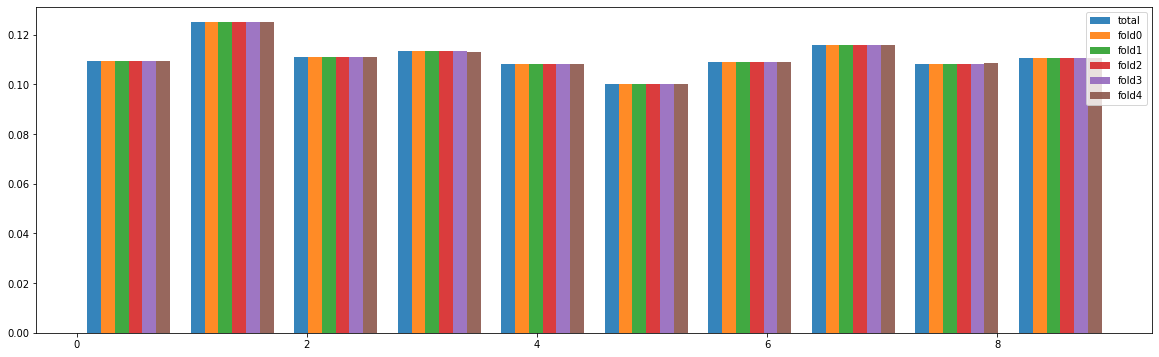

In [9]:
# 번호별 구성비 비교
fig = plt.figure(figsize=(20,6))
plt.hist([label_np, idx_lb_fold_0, idx_lb_fold_1, idx_lb_fold_2, idx_lb_fold_3, idx_lb_fold_4], 
         bins = 10, density=True, alpha=0.9, label = ['total', 'fold0', 'fold1', 'fold2', 'fold3', 'fold4'])
plt.legend(loc='upper right')
plt.show()

In [10]:
# Custome Dataset 만들기
class CustomDataset(Dataset):
  def __init__(self, datarole, labelrole, transform=None):
    self.image_list = datarole
    self.class_list = labelrole
    self.transform = transform
    self.len = datarole.shape[0]
  def __len__(self):
    return self.len
  def __getitem__(self, idx):
    img = self.image_list[idx]    
    label = self.class_list[idx]
    return img, label

In [11]:
# custome data 생성, dataloader : fold 1
custom_dataset = CustomDataset(idx_data_fold_1, idx_lb_fold_1)
dataloader = DataLoader(custom_dataset, batch_size=100, shuffle=True, drop_last=False)

In [12]:
print(len(custom_dataset),len(dataloader))

14004 141


Feature batch shape: torch.Size([100, 28, 28])
Labels batch shape: torch.Size([100])


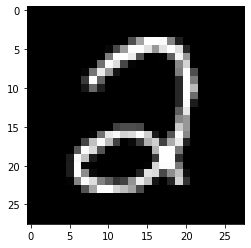

Label: 2


In [13]:
# image 출력
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#4. 5개 생성 fold 저장
- np.save

In [14]:
# path_data = "/content/drive/MyDrive/Data/MNIST/fold5/idx_data_fold_"
# path_lb = "/content/drive/MyDrive/Data/MNIST/fold5/idx_lb_fold_"

# for idx in range(5):
#   globals()["idx_data_fold_"+str(idx)+"_np"] = data.numpy()  
#   np.save(path_data + str(idx), globals()["idx_data_fold_"+str(idx)+"_np"])
#   globals()["idx_lb_fold_"+str(idx)+"_np"] = data.numpy()  
#   np.save(path_lb+str(idx), globals()["idx_lb_fold_"+str(idx)+"_np"])  
for idx in range(5):
  globals()["idx_data_fold_"+str(idx)+"_np"] = data.numpy()  
  np.save(DataDir+"MNIST/fold5/idx_data_fold_"+ str(idx), globals()["idx_data_fold_"+str(idx)+"_np"])
  np.save(DataDir+"MNIST/fold5/idx_lb_fold_"+str(idx), globals()["idx_lb_fold_"+str(idx)])  

#5. Cross Validation Set 생성(총 20개 set)
### - 5개 fold 활용(Train(60%), Validation(20%), Test(20%))
- itertools



In [15]:
#  Train set(60%, 3개 fold) 
iter_lst = list(itertools.combinations('01234', 3))
print("경우의 수:", len(iter_lst))
for x,y,z in iter_lst:
  print (x,y,z)

경우의 수: 10
0 1 2
0 1 3
0 1 4
0 2 3
0 2 4
0 3 4
1 2 3
1 2 4
1 3 4
2 3 4


In [16]:
# Train Set + Validation / Test set 결합
set_all = set(['0','1','2','3','4'])
result = []
for row in iter_lst:
  set_row = set(row)
  diff_row = list(set_all.difference(set_row))
  result.append([row] + diff_row)
  diff_row.reverse()
  result.append([row] + diff_row)
print("전체 경우의 수:", len(result))

for idx, (train_idx, valid_idx, test_idx) in enumerate(result):
  if idx // 5 == 0:
    print(train_idx)
    print(valid_idx)
    print(test_idx)

전체 경우의 수: 20
('0', '1', '2')
4
3
('0', '1', '2')
3
4
('0', '1', '3')
2
4
('0', '1', '3')
4
2
('0', '1', '4')
2
3


In [17]:
# 20개 Cross Validation Set별 Image Data / Label 파일 생성
print("fold_0:", len(idx_data_fold_0))
print("fold_1:", len(idx_data_fold_1))
print("fold_2:", len(idx_data_fold_2))
print("fold_3:", len(idx_data_fold_3))
print("fold_4:", len(idx_data_fold_4))
for idx, (train_idx, valid_idx, test_idx) in enumerate(result):
  # Image Data
  # Train
  globals()["data_trn_case_"+str(idx)] = torch.cat((globals()["idx_data_fold_"+train_idx[0]],
                                                  globals()["idx_data_fold_"+train_idx[1]],
                                                  globals()["idx_data_fold_"+train_idx[2]]),
                                                  0)
  # Validation
  globals()["data_vld_case_"+str(idx)] = globals()["idx_data_fold_"+valid_idx]
  # Test  
  globals()["data_tst_case_"+str(idx)] = globals()["idx_data_fold_"+test_idx]


  # Label Data
  # Train
  globals()["lb_trn_case_"+str(idx)] = np.concatenate((globals()["idx_lb_fold_"+train_idx[0]],
                                                  globals()["idx_lb_fold_"+train_idx[1]],
                                                  globals()["idx_lb_fold_"+train_idx[2]]),
                                                  axis = 0)
  # Validaiton  
  globals()["lb_vld_case_"+str(idx)] = globals()["idx_lb_fold_"+valid_idx]
  # Test
  globals()["lb_tst_case_"+str(idx)] = globals()["idx_lb_fold_"+test_idx]  

  # 결과 검증
  print("--- case of"," ", idx, "  ", "----")
  print("train:",train_idx, "valid:", valid_idx, "test:", test_idx )
  sum = len(globals()["data_trn_case_"+str(idx)])+len(globals()["data_vld_case_"+str(idx)])+len(globals()["data_tst_case_"+str(idx)])
  print("total num:", sum)
  print("Image Data//", "train_num:",len(globals()["data_trn_case_"+str(idx)]), "valid:", len(globals()["data_vld_case_"+str(idx)]), "test:", len(globals()["data_tst_case_"+str(idx)]))
  print("Label//", "train_num:",len(globals()["lb_trn_case_"+str(idx)]), "valid:", len(globals()["lb_vld_case_"+str(idx)]), "test:", len(globals()["lb_tst_case_"+str(idx)]))


fold_0: 14004
fold_1: 14004
fold_2: 14004
fold_3: 14004
fold_4: 13984
--- case of   0    ----
train: ('0', '1', '2') valid: 4 test: 3
total num: 70000
Image Data// train_num: 42012 valid: 13984 test: 14004
Label// train_num: 42012 valid: 13984 test: 14004
--- case of   1    ----
train: ('0', '1', '2') valid: 3 test: 4
total num: 70000
Image Data// train_num: 42012 valid: 14004 test: 13984
Label// train_num: 42012 valid: 14004 test: 13984
--- case of   2    ----
train: ('0', '1', '3') valid: 2 test: 4
total num: 70000
Image Data// train_num: 42012 valid: 14004 test: 13984
Label// train_num: 42012 valid: 14004 test: 13984
--- case of   3    ----
train: ('0', '1', '3') valid: 4 test: 2
total num: 70000
Image Data// train_num: 42012 valid: 13984 test: 14004
Label// train_num: 42012 valid: 13984 test: 14004
--- case of   4    ----
train: ('0', '1', '4') valid: 2 test: 3
total num: 70000
Image Data// train_num: 41992 valid: 14004 test: 14004
Label// train_num: 41992 valid: 14004 test: 14004


In [18]:
for idx in range(20):
  globals()["data_trn_case_"+str(idx)+"_np"] = data.numpy()  
  np.save(DataDir + "MNIST/fold5/data_trn_case_" + str(idx), globals()["data_trn_case_"+str(idx)+"_np"])
  globals()["data_vld_case_"+str(idx)+"_np"] = data.numpy()  
  np.save(DataDir + "MNIST/fold5/data_vld_case_" + str(idx), globals()["data_vld_case_"+str(idx)+"_np"])
  globals()["data_tst_case_"+str(idx)+"_np"] = data.numpy()  
  np.save(DataDir + "MNIST/fold5/data_tst_case_" + str(idx), globals()["data_tst_case_"+str(idx)+"_np"])

  np.save(DataDir + "MNIST/fold5/lb_trn_case_" + str(idx), globals()["lb_trn_case_"+str(idx)])
  np.save(DataDir + "MNIST/fold5/lb_vld_case_" + str(idx), globals()["lb_vld_case_"+str(idx)])
  np.save(DataDir + "MNIST/fold5/lb_tst_case_" + str(idx), globals()["lb_tst_case_"+str(idx)])


In [19]:
# custome data 생성, dataloader : fold 1
custom_dataset = CustomDataset(data_trn_case_0, lb_trn_case_0)
dataloader = DataLoader(custom_dataset, batch_size=100, shuffle=True, drop_last=False)

Feature batch shape: torch.Size([100, 28, 28])
Labels batch shape: torch.Size([100])


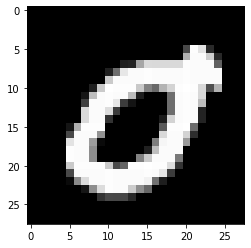

Label: 0


In [20]:
# image 출력
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [30]:
len(file)

14004

# VAE 모델만들기

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.8.0


In [32]:
x_train,y_train, x_val_1, y_val_1, x_val_2, y_val_2, x_val_3, y_val_3, x_test,y_test  = idx_data_fold_0, idx_lb_fold_0, idx_data_fold_1, idx_lb_fold_1, idx_data_fold_2, idx_lb_fold_2, idx_data_fold_3, idx_lb_fold_3, idx_data_fold_4, idx_lb_fold_4

In [35]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [36]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

In [37]:
print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train),np.shape(x_test)))

Datasets_train_shape:(14004, 784)  Datasets_test_shape:(13984, 784)


In [50]:
# network parameters
input_shape = np.shape(x_train[0])[0]
original_dim= input_shape
intermediate_dim = 512
latent_dim = 2

#### Encoder

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_shape (InputLayer)       [(None, 784)]        0           []                               
                                                                                                  
 encoder_hidden1 (Dense)        (None, 512)          401920      ['input_shape[0][0]']            
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['encoder_hidden1[0][0]']        
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['encoder_hidden1[0][0]']        
                                                                                            

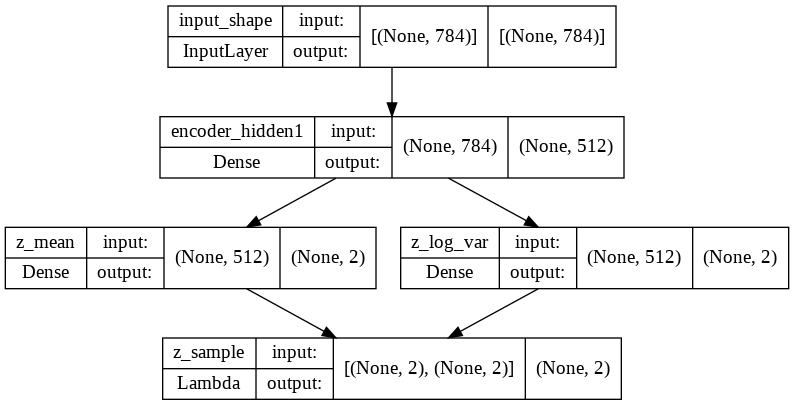

In [42]:
def encoder():
  # 인코더의 입력층을 생성합니다.
  inputs = Input(shape=(input_shape,), name='input_shape')

  # 인코더의 hidden층을 생성합니다. 500개의 유닛을 사용했습니다.
  encoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='encoder_hidden1')(inputs)

  # 평균(mean)과 표준편차(sigma)층을 정의합니다. 
  # 이때 sigma 대신 log variance를 사용합니다. 이는 신경망의 출력은 음수를 가질 수 있지만 sigma는 항상 양수여야 하기 때문입니다. 
  # 각각 2개의 유닛을 사용했습니다.
  z_mean = layers.Dense(latent_dim, name='z_mean')(encoder_hidden)
  z_log_var = layers.Dense(latent_dim, name='z_log_var')(encoder_hidden)

  # 평균과 표준편차를 래핑하여 Z_sampling층을 만듭니다.

  # Z 샘플링 함수 생성
  def sampling(args):
      z_mean, z_log_var = args
      batch = shape(z_mean)[0]
      dim = shape(z_mean)[1]

      # by default, random_normal has mean = 0 and std = 1.0
      # Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) ε추출 
      epsilon = tf.compat.v2.random.normal(shape=(batch, dim))
      return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon

  #  layers.Lambda API 래핑에 사용할 함수와, 유닛수(n,)를 지정합니다.
  z_sampling = layers.Lambda(sampling, (latent_dim,), name='z_sample')([z_mean, z_log_var])

  # 하나의 입력과 다중충력을 포함하는 encoder 모델을 만듭니다.   
  return Model(inputs,[z_mean,z_log_var,z_sampling], name='encoder')

encoder = encoder()

# 인코더 네트워크를 확인합니다.
encoder.summary()

from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

#### Decoder

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_z (InputLayer)        [(None, 2)]               0         
                                                                 
 decoder_hidden (Dense)      (None, 512)               1536      
                                                                 
 output (Dense)              (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


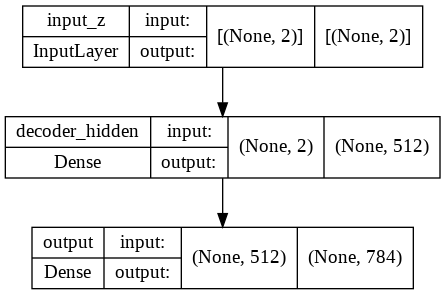

In [43]:
def decoder():
  
  # 디코더의 입력층을 생성합니다. (Decoder의 입력은 latent입니다)
  input_z = Input(shape=(latent_dim,), name='input_z')

  # 디코더의 hidden층을 생성합니다. 인코더와 동일하게 500개의 유닛을 사용했습니다.
  decoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='decoder_hidden')(input_z)

  # 디코더의 출력층은 인코더 입력벡터 수만큼 유닛을 사용합니다.
  outputs = layers.Dense(original_dim, activation='sigmoid',name='output')(decoder_hidden)

  return Model(input_z, outputs, name='decoder')

decoder = decoder()

# 디코더의 네트워크 확인.
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

#### VAE model

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               403972    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


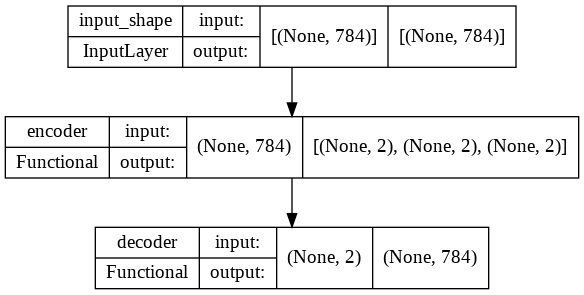

In [44]:
def vae():
  # vae는 입력으로 이미지로 들어와 encoder를 통해 z_sampling 되어 decoder로 출력됩니다.  
  inputs = Input(shape=(input_shape,), name='input_shape')
  outputs = decoder(encoder(inputs)[2]) #[0]:z_mean, [1]:z_log_var,[2]:z_sampling
  
  return Model(inputs,outputs, name='vae_mlp')

#VAE 모델 정의
model = vae()

#모델 네트워크 확인 
model.summary()
plot_model(model,to_file='vae_mlp.png',show_shapes=True)

#### model fit

In [45]:
# Hyperparameters
num_epochs = 100
batch_size = 20
learning_rate = 1e-3

In [46]:
# 모델 학습 loss, optimizer 정의
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
def vae_loss(x,recon_x):
    # (1)Reconstruct loss (Marginal_likelihood) : Cross-entropy 
    z_mean,z_log_var,z_sampling = encoder(x)
    recon_x=decoder(z_sampling)
    reconstruction_loss = binary_crossentropy(x,recon_x)
    #reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= original_dim
    # (2) KL divergence(Latent_loss)
    kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean)+ tf.exp(z_log_var)- z_log_var -1, 1)    
    return tf.reduce_mean(reconstruction_loss + kl_loss) #ELBO(=VAE_loss)

model.compile(optimizer=adam,loss=vae_loss)

In [47]:
# 모델 학습
hist = model.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size )
#학습된 VAE 모델 저장 
model.save_weights('vae_bracket.h5')

Epoch 1/100
701/701 [==============================] - 8s 9ms/step - loss: 193.1138
Epoch 2/100
701/701 [==============================] - 7s 10ms/step - loss: 173.0271
Epoch 3/100
701/701 [==============================] - 10s 14ms/step - loss: 169.9805
Epoch 4/100
701/701 [==============================] - 8s 11ms/step - loss: 167.5822
Epoch 5/100
701/701 [==============================] - 8s 11ms/step - loss: 165.7755
Epoch 6/100
701/701 [==============================] - 10s 15ms/step - loss: 164.2280
Epoch 7/100
701/701 [==============================] - 10s 14ms/step - loss: 162.9684
Epoch 8/100
701/701 [==============================] - 7s 10ms/step - loss: 161.7865
Epoch 9/100
701/701 [==============================] - 7s 9ms/step - loss: 160.7417
Epoch 10/100
701/701 [==============================] - 7s 10ms/step - loss: 159.8055
Epoch 11/100
701/701 [==============================] - 7s 10ms/step - loss: 159.0925
Epoch 12/100
701/701 [==============================] - 6s 9ms

#### 원본 vs 복원 이미지

In [49]:
recon_x_test = model.predict(x_test)

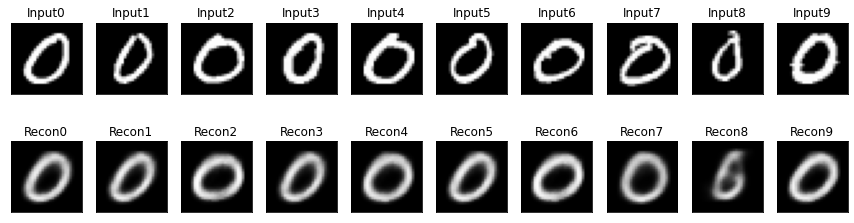

In [55]:
n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28,28), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(28, 28),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()

#### 2D 공간 데이터

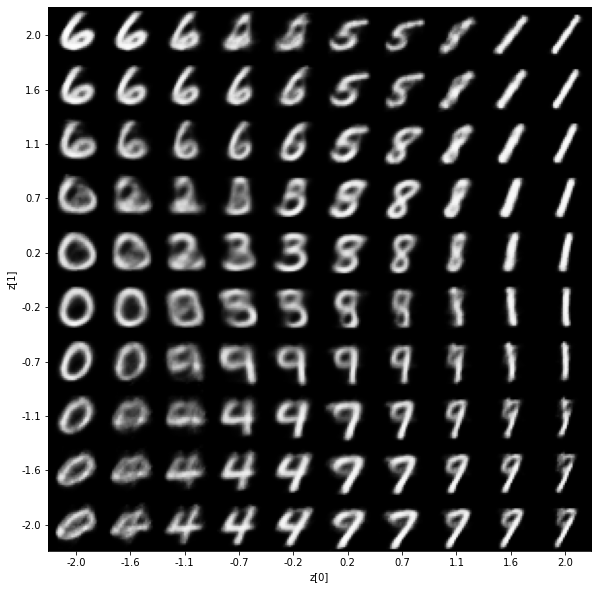

In [57]:
# 학습모델이 생성한 Manifold를 plot하는 함수 정의
def plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mnist"):
    encoder, decoder = models
    x_test, y_test = data
    filename = "digits_over_latent.png"
    # display a 30x30 2D manifold of digitsa
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()
    
plot_results(models = (encoder, decoder),
                 data = (x_test, y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")

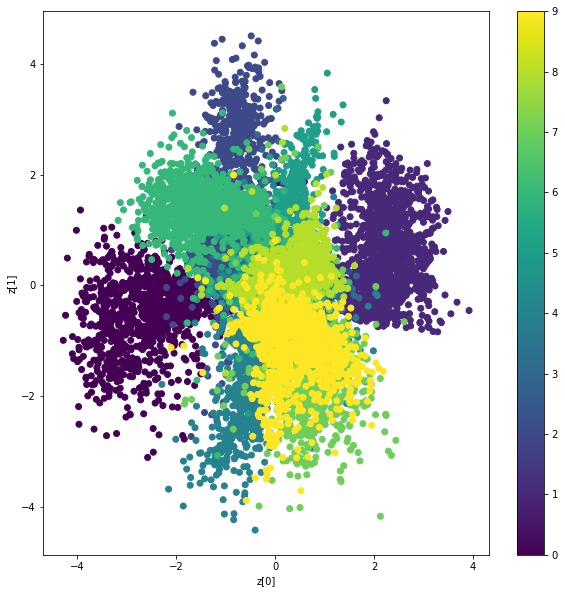

In [58]:
def tsne_plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    #filename = os.path.join(model_name, "vae_mean.png")
    filename = "vae_mean.png"
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

tsne_plot_results(models = (encoder, decoder),
                 data = (x_test, y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [59]:
def linear_interpolation(x_from, x_to, steps=10):
    n = steps + 1

    t_from = x_from
    t_to = x_to

    diff = t_to - t_from
    inter = np.zeros((n, t_from.shape[0]))
    for i in range(n):
        inter[i] = t_from + i / steps * diff

    return decoder.predict(inter)

In [60]:
target_a = np.array([1, 1]) # 타겟 시작 좌표 
target_b = np.array([10, 10]) # 타겟 끝 좌표
z_decoder_imgs = linear_interpolation(target_a,target_b, 10)

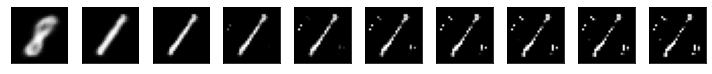

In [62]:
N = 1
M = 10
img_size= 28
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(N):
    for j in range(M):
        k = i * M + j
        ax = fig.add_subplot(N, M, k+1)
        ax.imshow(np.reshape(z_decoder_imgs[k], (img_size, img_size)), cmap=plt.cm.gist_gray)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.tight_layout()